In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [6]:
#欠損値の調査
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
#特徴量TITLEの追加
#title_map = {
#    'Mr': 'Mr',
#    'Mrs': 'Mrs',
#    'Miss': 'Miss',
#    'Master': 'Master',
#     'Don': 'Rare', 'Rev': 'Rare', 'Dr': 'Rare', 'Mme': 'Mrs',
#     'Ms': 'Miss', 'Major': 'Rare', 'Lady': 'Rare', 'Sir': 'Rare',
#     'Mlle': 'Miss', 'Col': 'Rare', 'Capt': 'Rare',
#     'Countess': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
# }
# for dataset in [train_data, test_data]:
#     dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
#     dataset['Title'] = dataset['Title'].map(title_map)
#     dataset['Title'] = dataset['Title'].fillna('Rare')

#Title排除につき、コメントアウト
# for dataset in [train_data, test_data]:
#     dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
#     dataset['Title'] = dataset['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs'] else 'Other')

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# 家族関連特徴量の作成
for dataset in [train_data, test_data]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

[0]	validation_0-logloss:0.64923	validation_1-logloss:0.66610
[100]	validation_0-logloss:0.38182	validation_1-logloss:0.45894
[200]	validation_0-logloss:0.37147	validation_1-logloss:0.45619
[230]	validation_0-logloss:0.37026	validation_1-logloss:0.45572


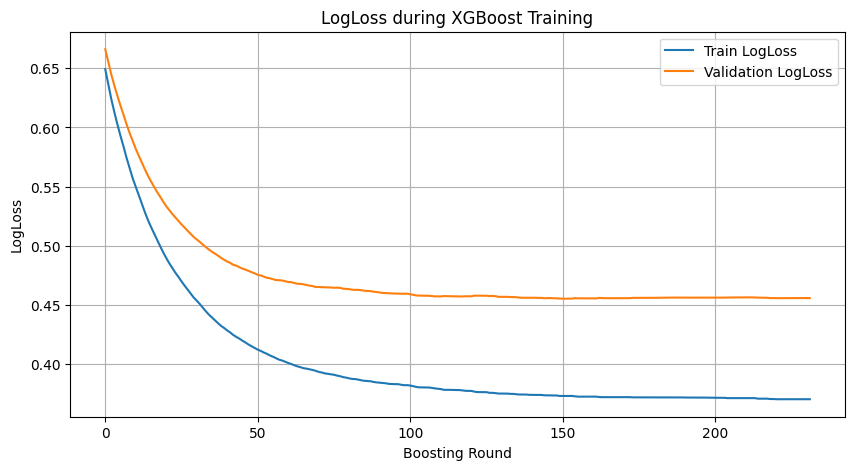

Best boosting round: 151
Your early-stopping XGBoost submission was successfully saved.


In [24]:
# 目的変数
# y = train_data['Survived']
y = train_data['Survived'].astype(int)

# 特徴量
#features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Fare', 'Title', 'FamilySize', 'IsAlone']
#features = ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'FamilySize', 'IsAlone']
# 特徴量からTitleを排除
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone']
X = train_data[features]
X_test = test_data[features]

# カラムの型ごとに処理を分ける
#numeric_features = ['Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize']
numeric_features = ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone']
#categorical_features = ['Sex', 'Title']
categorical_features = ['Sex']

# 数値データ:中央値で補完
numeric_transformer = SimpleImputer(strategy='median')

# カテゴリデータ:最頻値で補完
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 前処理をまとめる
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 前処理+モデルを連携したパイプライン
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(n_estimators=100, max_depth=9, random_state=1, min_samples_leaf=2))
# ])

# XGBoostモデルのパイプライン
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1))
# ])

# クロスバリデーション
#scores = cross_val_score(pipeline, X, y, cv=5)
#print('各分割でのスコア：', scores)
#print('平均スコア：', scores.mean())

#pipeline.fit(X, y)
#predictions = pipeline.predict(X_test)

# GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [50, 100],
#     'classifier__max_depth': [3, 5, 7],
#     'classifier__learning_rate':[0.05, 0.1]
#     # 'classifier__min_samples_leaf': [1, 2, 4, 6]
# }

# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid = param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=1
# )
# grid_search.fit(X, y)
# print('Best params：', grid_search.best_params_)
# print('Best crss-validation score：', grid_search.best_score_)

# best_model = grid_search.best_estimator_
# predictions = best_model.predict(X_test)

# 前処理を先に適用 20250521
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

# train/valid分割 20250521
X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed, y, test_size=0.2, random_state=1
)

# XGBoostモデル 20250521
model = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=2,
    min_child_weight=1,
    reg_lambda=1,
    reg_alpha=0.5,
    early_stopping_rounds=80,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

#loglossの推移の可視化　20250521
evals_result = model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
valid_logloss = evals_result['validation_1']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train LogLoss')
plt.plot(valid_logloss, label='Validation LogLoss')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('LogLoss during XGBoost Training')
plt.legend()
plt.grid(True)
plt.show()

# テストデータ　20250521
predictions = model.predict(X_test_processed)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print(f"Best boosting round: {model.best_iteration}")
print("Your early-stopping XGBoost submission was successfully saved.")

In [14]:
# 手動チューニング用：subsample
for subsample in [0.6, 0.7, 0.8, 0.9]:
    print(f"\n▶ testing subsample={subsample}")
    model.set_params(subsample=subsample)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        verbose=False
    )
    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter:{bi}, valid_logloss:{vl:.5f}")



▶ testing subsample=0.6
  best_iter:141, valid_logloss:0.45633

▶ testing subsample=0.7
  best_iter:108, valid_logloss:0.45787

▶ testing subsample=0.8
  best_iter:141, valid_logloss:0.45742

▶ testing subsample=0.9
  best_iter:110, valid_logloss:0.45485


In [13]:
# 手動チューニング用：colsample_bytree
for cs in [0.6, 0.7, 0.8, 0.9]:
    print(f"\n▶ testing colsample_bytree = {cs}")
    model.set_params(colsample_bytree=cs)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )

    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter: {bi}, valid_logloss: {vl:.5f}")


▶ testing colsample_bytree = 0.6
  best_iter: 140, valid_logloss: 0.46049

▶ testing colsample_bytree = 0.7
  best_iter: 140, valid_logloss: 0.46049

▶ testing colsample_bytree = 0.8
  best_iter: 110, valid_logloss: 0.45858

▶ testing colsample_bytree = 0.9
  best_iter: 110, valid_logloss: 0.45485


In [15]:
# 手動チューニング用：gamma
for gamma in [0, 1, 2, 5]:
    print(f"\n▶ testing gamma = {gamma}")
    model.set_params(gamma=gamma)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )

    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter: {bi}, valid_logloss: {vl:.5f}")


▶ testing gamma = 0
  best_iter: 110, valid_logloss: 0.45658

▶ testing gamma = 1
  best_iter: 110, valid_logloss: 0.45485

▶ testing gamma = 2
  best_iter: 160, valid_logloss: 0.45060

▶ testing gamma = 5
  best_iter: 252, valid_logloss: 0.46029


In [17]:
# 手動チューニング用：min_child_weight
for min_child_weight in [1, 3, 5]:
    print(f"\n▶ testing min_child_weight = {min_child_weight}")
    model.set_params(min_child_weight=min_child_weight)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )

    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter: {bi}, valid_logloss: {vl:.5f}")


▶ testing min_child_weight = 1
  best_iter: 160, valid_logloss: 0.45060

▶ testing min_child_weight = 3
  best_iter: 148, valid_logloss: 0.45580

▶ testing min_child_weight = 5
  best_iter: 220, valid_logloss: 0.46208


In [20]:
# 手動チューニング用：reg_lambda
for reg_lambda in [0.5, 1, 5]:
    print(f"\n▶ testing reg_lambda = {reg_lambda}")
    model.set_params(reg_lambda=reg_lambda)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )

    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter: {bi}, valid_logloss: {vl:.5f}")


▶ testing reg_lambda = 0.5
  best_iter: 249, valid_logloss: 0.46235

▶ testing reg_lambda = 1
  best_iter: 220, valid_logloss: 0.46208

▶ testing reg_lambda = 5
  best_iter: 249, valid_logloss: 0.46397


In [23]:
# 手動チューニング用：reg_alpha
for reg_alpha in [0.5, 1, 5]:
    print(f"\n▶ testing reg_alpha = {reg_alpha}")
    model.set_params(reg_alpha=reg_alpha)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=False
    )

    bi = model.best_iteration
    vl = model.evals_result()['validation_1']['logloss'][bi]
    print(f"  best_iter: {bi}, valid_logloss: {vl:.5f}")


▶ testing reg_alpha = 0.5
  best_iter: 151, valid_logloss: 0.45523

▶ testing reg_alpha = 1
  best_iter: 220, valid_logloss: 0.45544

▶ testing reg_alpha = 5
  best_iter: 245, valid_logloss: 0.47631
